In [3]:
import pandas as pd
import numpy as np

from scipy import stats
from collections import defaultdict
from sklearn import preprocessing

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [5]:
cdf = pd.read_json('data/headline-graph.json', lines=True)

In [6]:
cdf.head(10)

,acc,acc_scaled,d1,d2,pair
0,0.918274,2.139535,buzzfeed.com,sputniknews.com,buzzfeed.com - sputniknews.com
1,0.913906,2.065381,buzzfeed.com,rt.com,buzzfeed.com - rt.com
2,0.912524,2.041933,apnews.com,buzzfeed.com,apnews.com - buzzfeed.com
3,0.896893,1.776583,dailykos.com,sputniknews.com,dailykos.com - sputniknews.com
4,0.890221,1.663331,buzzfeed.com,thehill.com,buzzfeed.com - thehill.com
5,0.890204,1.663042,buzzfeed.com,msnbc.com,buzzfeed.com - msnbc.com
6,0.888759,1.638510,bloomberg.com,buzzfeed.com,bloomberg.com - buzzfeed.com
7,0.883500,1.549230,dailykos.com,rt.com,dailykos.com - rt.com
8,0.882814,1.537587,msnbc.com,sputniknews.com,msnbc.com - sputniknews.com
9,0.882762,1.536703,breitbart.com,buzzfeed.com,breitbart.com - buzzfeed.com


In [7]:
adf = pd.read_json('data/audience-graph.json', lines=True)

In [8]:
adf.head(10)

,d1,d2,kt_corr,kt_p,kt_scaled,pair,pr_corr,pr_p,pr_scaled,sp_corr,sp_p,sp_scaled
0,dailycaller.com,wsj.com,0.256906,0,-0.019349,dailycaller.com - wsj.com,0.338547,0,-0.168581,0.259665,0,-0.034542
1,bloomberg.com,dailycaller.com,0.163152,0,-0.740570,bloomberg.com - dailycaller.com,0.204260,0,-0.809822,0.164993,0,-0.748915
2,dailycaller.com,sputniknews.com,0.142810,0,-0.897052,dailycaller.com - sputniknews.com,0.164252,0,-1.000864,0.143515,0,-0.910990
3,dailycaller.com,msnbc.com,0.080875,0,-1.373496,dailycaller.com - msnbc.com,0.072293,0,-1.439977,0.081447,0,-1.379344
4,dailycaller.com,nytimes.com,0.182257,0,-0.593596,dailycaller.com - nytimes.com,0.241186,0,-0.633494,0.187963,0,-0.575592
5,dailycaller.com,huffingtonpost.com,0.116359,0,-1.100535,dailycaller.com - huffingtonpost.com,0.131966,0,-1.155032,0.117995,0,-1.103555
6,cnn.com,dailycaller.com,0.190676,0,-0.528836,cnn.com - dailycaller.com,0.262803,0,-0.530268,0.196688,0,-0.509754
7,dailycaller.com,foxnews.com,0.519499,0,2.000697,dailycaller.com - foxnews.com,0.755614,0,1.822966,0.525138,0,1.968675
8,dailycaller.com,washingtonpost.com,0.220205,0,-0.301676,dailycaller.com - washingtonpost.com,0.269980,0,-0.496000,0.225318,0,-0.293716
9,dailycaller.com,rt.com,0.210389,0,-0.377187,dailycaller.com - rt.com,0.260021,0,-0.543556,0.211831,0,-0.395488


In [9]:
C_SCORES = defaultdict(dict)
for r in cdf.itertuples():
    C_SCORES[r.d1][r.d2] = r.acc
    C_SCORES[r.d2][r.d1] = r.acc

In [10]:
A_SCORES = defaultdict(dict)
for r in adf.itertuples():
    A_SCORES[r.d1][r.d2] = r.kt_corr
    A_SCORES[r.d2][r.d1] = r.kt_corr

In [11]:
DOMAINS = list(C_SCORES.keys())
DOMAINS = [d for d in DOMAINS if d not in {'rt.com', 'sputniknews.com'}]

In [12]:
rows = []
for d1 in DOMAINS:
    
    other_domains = [d2 for d2 in DOMAINS if d2 != d1]
    
    a_scores =  preprocessing.scale([A_SCORES[d1][d2] for d2 in other_domains])
    c_scores = -preprocessing.scale([C_SCORES[d1][d2] for d2 in other_domains])
    
    for d2, av, cv in zip(other_domains, a_scores, c_scores):
        rows.append((d1, d2, av, cv))

In [13]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'av', 'cv'))

In [14]:
stats.pearsonr(df.av, df.cv)

(0.26627051575700744, 9.369982359140575e-05)

In [15]:
stats.kendalltau(df.av, df.cv)

KendalltauResult(correlation=0.1590795169742538, pvalue=0.0006050809705312268)

In [16]:
stats.linregress(df.av, df.cv)

LinregressResult(slope=0.2662705157570074, intercept=1.8372968839713309e-16, rvalue=0.26627051575700744, pvalue=9.369982359140551e-05, stderr=0.06683432488532662)

In [17]:
df['cv_av_diff'] = df.cv - df.av
df['pair'] = df.apply(lambda r: f'{r.d1} -> {r.d2}', 1)

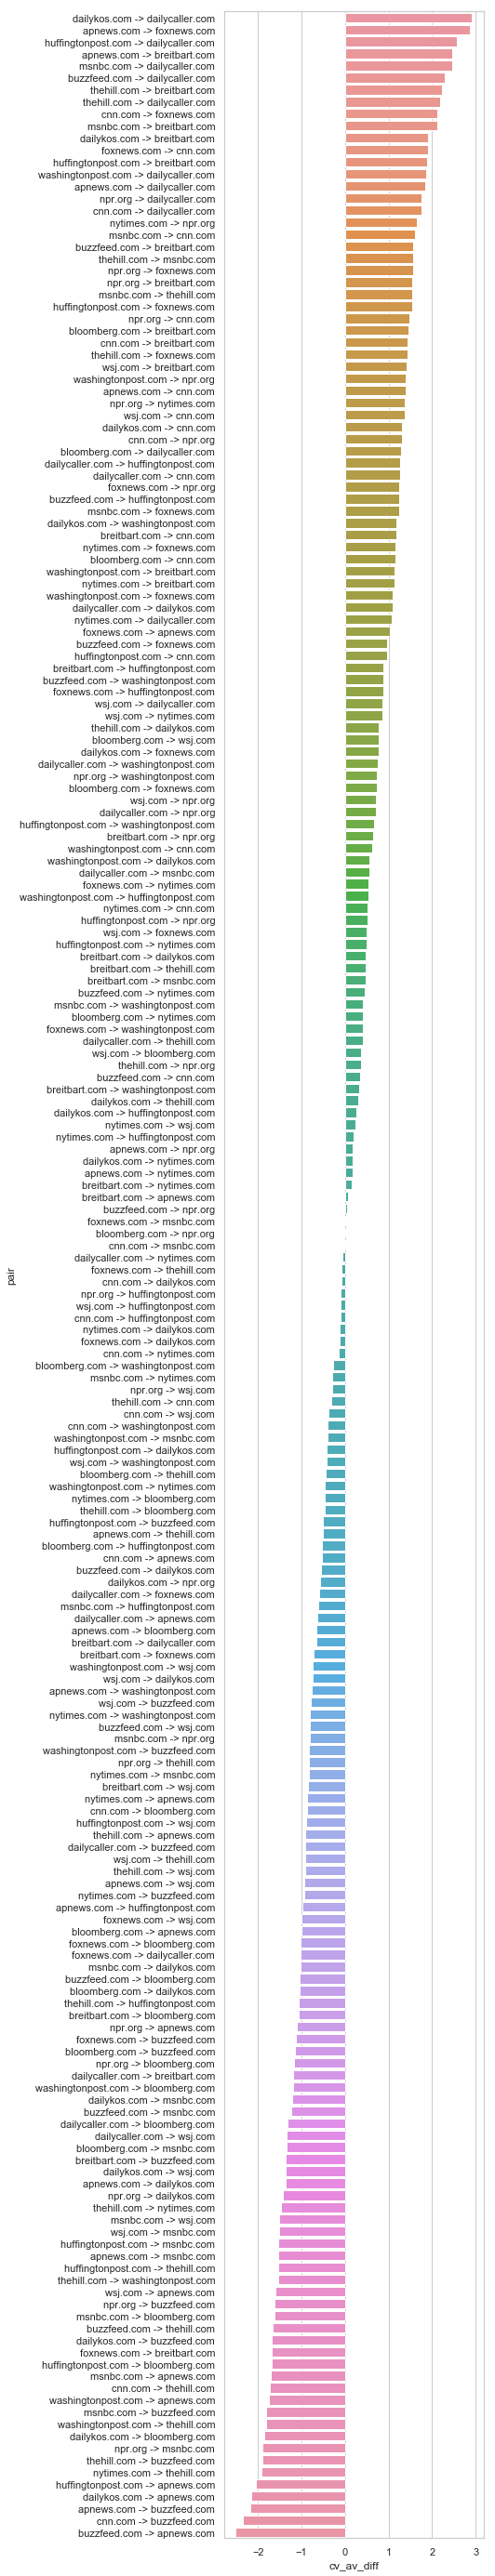

In [19]:
plt.figure(figsize=(5,50))
sns.barplot(y='pair', x='cv_av_diff', data=df.sort_values('cv_av_diff', ascending=False))

In [20]:
points = (alt
    .Chart(df)
    .mark_circle(size=50)
    .encode(x='av', y='cv', tooltip='pair'))

In [21]:
xfit = np.linspace(df.av.min(), df.av.max())
yfit = np.poly1d(np.polyfit(df.av, df.cv, 1))(xfit)
fit_df = pd.DataFrame(list(zip(xfit, yfit)), columns=('x', 'y'))

In [27]:
fit = (alt
    .Chart(fit_df, width=400, height=400)
    .mark_line()
    .encode(
        x=alt.X('x', scale=alt.Scale(domain=[-3, 3])),
        y=alt.Y('y', scale=alt.Scale(domain=[-3, 3])),
    ))

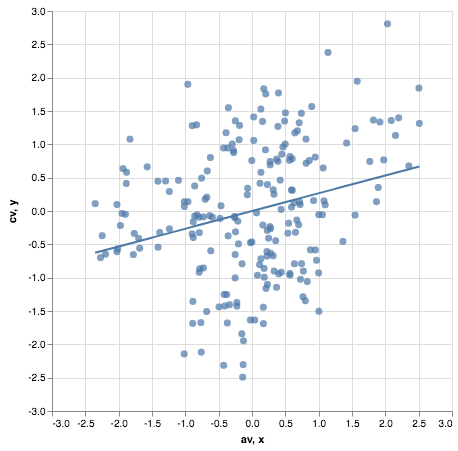

In [28]:
points + fit

In [29]:
def ac_corr(domain, plot=False):
    
    ddf = df[df.d1==domain]
    corr, p = stats.pearsonr(ddf.cv, ddf.av)
    
    if plot:
        
        pdf = ddf.melt('d2', ['cv', 'av'])
        order = ddf.sort_values('cv', ascending=False).d2
        
        print(d, corr, p)
        plt.figure(figsize=(3,5))
        sns.barplot(x='value', y='d2', hue='variable', data=pdf, order=order)
        plt.show()
    
    return corr, p

In [30]:
rows = []
for d in DOMAINS:
    corr, p = ac_corr(d)
    rows.append((d, corr, p))

In [31]:
gdf = pd.DataFrame(rows, columns=('domain', 'corr', 'p'))

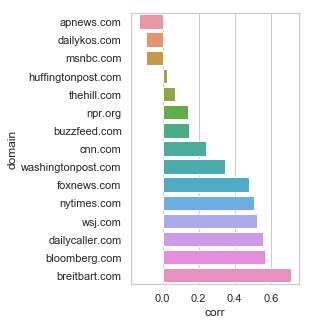

In [32]:
plt.figure(figsize=(3,5))
sns.barplot(x='corr', y='domain', data=gdf.sort_values('corr'))

apnews.com
apnews.com -0.13169116365848524 0.6536002469601638


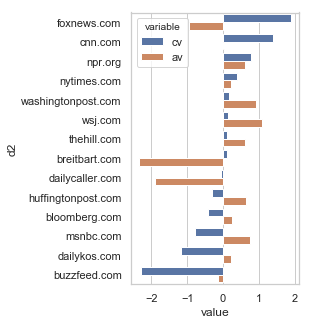

dailykos.com
dailykos.com -0.09037052645592775 0.7586615505607592


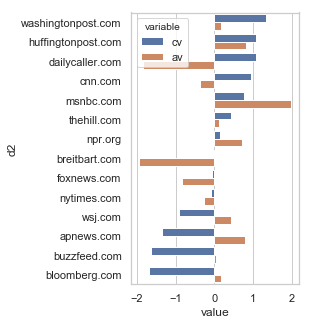

msnbc.com
msnbc.com -0.08946344587562612 0.7610193732705177


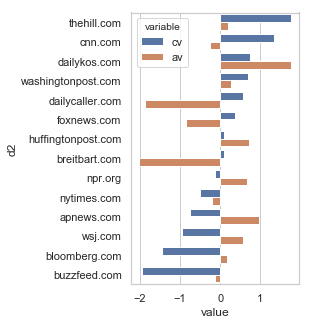

huffingtonpost.com
huffingtonpost.com 0.022738295693096586 0.9384997315843704


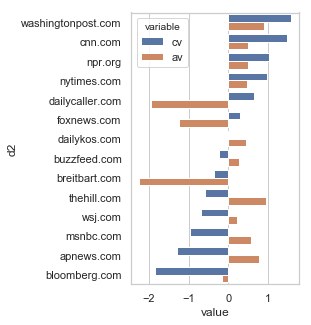

thehill.com
thehill.com 0.06698999193113467 0.8200050676475934


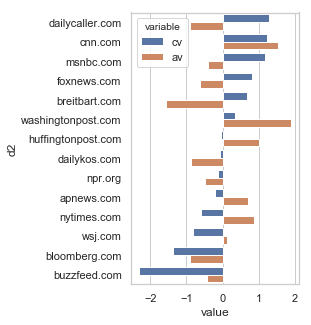

npr.org
npr.org 0.13897785559321055 0.6356167072928771


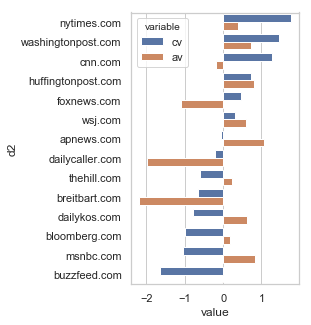

buzzfeed.com
buzzfeed.com 0.144065130524668 0.6231703553231661


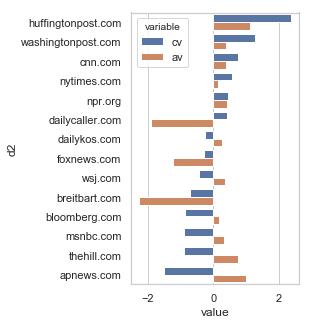

cnn.com
cnn.com 0.24321103969224475 0.40211016366822544


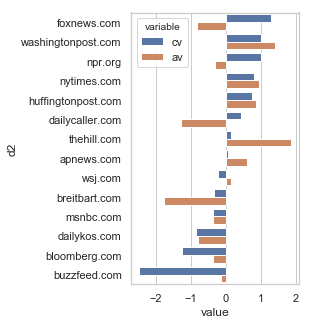

washingtonpost.com
washingtonpost.com 0.34746659407837416 0.22350140313477135


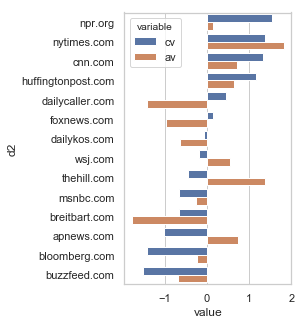

foxnews.com
foxnews.com 0.4776140372726027 0.08413482009236635


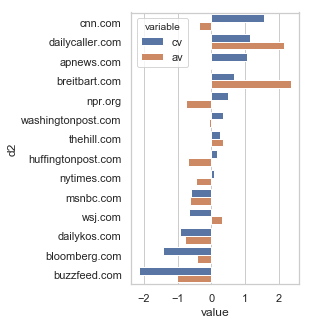

nytimes.com
nytimes.com 0.5078660641487007 0.0637332515829189


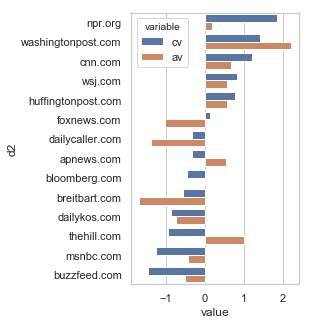

wsj.com
wsj.com 0.5225276859886466 0.05524246814614291


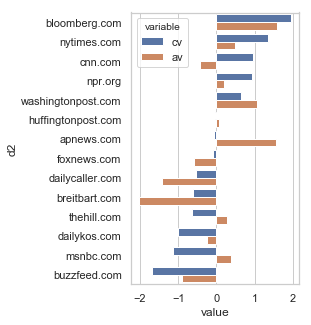

dailycaller.com
dailycaller.com 0.5560322204103749 0.03894864880120825


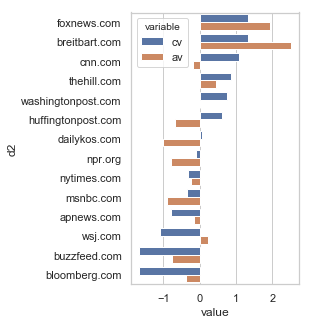

bloomberg.com
bloomberg.com 0.5663404753606086 0.03473723473586743


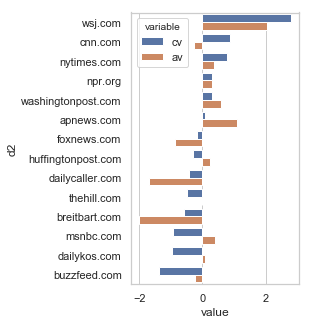

breitbart.com
breitbart.com 0.7117534816514892 0.004301237168290662


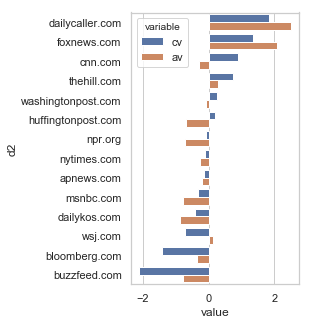

In [33]:
for d in gdf.sort_values('corr').domain:
    print(d)
    ac_corr(d, True)